In [11]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split         # Split data into train and test set
from sklearn.metrics import classification_report            # Summary of classifier performance

from utils import get_df, evaluate_classifier

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}

# Set global seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 30 ms


In [12]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 148 ms


In [13]:
ds.close()

time: 35.6 ms


In [14]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 9 s


In [15]:
# Create the df format to be used by scikit-learn
for i, polarization in enumerate(['VV', 'VH', 'VV-VH']):
    df_polarization = get_df(polygons_year=2019, 
                             satellite_dates=slice('2018-01-01', '2019-12-31'), 
                             fields='all', 
                             satellite='all', 
                             polarization=polarization,
                             netcdf_path=netcdf_path)
    
    # Extract a mapping of field_ids to crop type
    if i == 0:
        df_sklearn = df_polarization[['field_id', 'afgkode', 'afgroede']]
    
    # Pivot the df (https://stackoverflow.com/a/37790707/12045808)
    df_polarization = df_polarization.pivot(index='field_id', columns='date', values='stats_mean')
    
    # Add polarization to column names
    df_polarization.columns = [str(col)[:10]+f'_{polarization}' for col in df_polarization.columns]  
    
    # Merge the polarization dataframes into one dataframe
    df_polarization = df_polarization.reset_index()  # Creates new indices and a 'field_id' column (field id was used as indices before)
    df_sklearn = pd.merge(df_sklearn, df_polarization, on='field_id') 
        
# Drop fields having nan values
df_sklearn = df_sklearn.dropna()

# The merge operation for some reason made duplicates (there was a bug reported on this earlier), so drop duplicates and re-index the df
df_sklearn = df_sklearn.drop_duplicates().reset_index(drop=True)

time: 28.1 s


In [16]:
df_sklearn_remapped = df_sklearn.copy()

df_sklearn_remapped.insert(3, 'Crop type', '')
df_sklearn_remapped.insert(4, 'Label ID', 0)
mapping_dict = {}
class_names = [] 
i = 0
for key, value in mapping_dict_crop_types.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
    if value not in class_names:
        class_names.append(value)
        mapping_dict[value] = i
        i += 1
    
for key, value in mapping_dict.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
print(f"Crop types: {class_names}")

Crop types: ['Potato', 'Spring barley', 'Winter barley', 'Spring wheat', 'Winter wheat', 'Winter rye', 'Spring oat', 'Maize', 'Rapeseed', 'Permanent grass', 'Willow', 'Forest']
time: 227 ms


In [18]:
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,5:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,4])  # The column 'afgkode'

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=RANDOM_SEED)

print(f"Train samples:      {len(y_train)}")
print(f"Test samples:       {len(y_test)}")
print(f"Number of features: {len(X[0,:])}")

Train samples:      31033
Test samples:       13300
Number of features: 231
time: 1.09 s


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression          
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# From https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# Note: GaussianClassifier does not work (maybe requires too much training - kernel restarts in jupyter)
names = [
    "Nearest Neighbors", 
    "Decision Tree", 
    "Random Forest", 
    "Logistic Regression",
    "Linear SVM", 
    "RBF SVM",
    "Neural Net"
    ]

N_JOBS=24
classifiers = [
    GridSearchCV(KNeighborsClassifier(), 
                 param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8]}, 
                 refit=True, cv=5, n_jobs=N_JOBS),
    GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_SEED), 
                 param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8]}, 
                 refit=True, cv=5, n_jobs=N_JOBS),
    GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED), 
                 param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8], 
                             'n_estimators': [6, 8, 10, 12, 14], 
                             'max_features': [1, 2, 3]},
                 refit=True, cv=5, n_jobs=N_JOBS),
    GridSearchCV(LogisticRegression(random_state=RANDOM_SEED),
                 param_grid={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1],
                             'penalty': ['l1', 'l2']},
                 refit=True, cv=5, n_jobs=N_JOBS),
    GridSearchCV(SVC(kernel='linear', random_state=RANDOM_SEED),
                 param_grid={'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]},
                 refit=True, cv=5, n_jobs=N_JOBS),
    GridSearchCV(SVC(kernel='rbf', random_state=RANDOM_SEED),
                 param_grid={'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]},
                 refit=True, cv=5, n_jobs=N_JOBS),
    GridSearchCV(MLPClassifier(max_iter=1000, random_state=RANDOM_SEED),
                 param_grid={'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
                             'hidden_layer_sizes': [(50,50,50), (100,)],
                             'activation': ['tanh', 'relu'],
                             'learning_rate': ['constant','adaptive']},
                 refit=True, cv=5, n_jobs=N_JOBS)
    ]

clf_trained_dict = {}
report_dict = {}
cm_dict = {}

# TODO: Also calculate uncertainties - ie. use multiple random seeds.
#       Create df (with cols [Clf_name, Random_seed, Acc., Prec., Recall, F1-score]) and loop over random seeds
#       See following on how to format pandas dataframe to get the uncertainties into the df
#       https://stackoverflow.com/questions/46584736/pandas-change-between-mean-std-and-plus-minus-notations

for name, clf in zip(names, classifiers):
    # Evaluate classifier
    print("-------------------------------------------------------------------------------")
    print(f"Evaluating classifier: {name}")
    clf_trained, _, _, results_report, cnf_matrix = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)      
    print(f"The best parameters are {grid_trained.best_params_} with a score of {grid_trained.best_score_:2f}")
    
    # Save results in dicts
    clf_trained_dict[name] = clf_trained
    report_dict[name] = results_report 
    cm_dict[name] = cnf_matrix

-------------------------------------------------------------------------------
Evaluating classifier: Nearest Neighbors


In [ ]:
# Loop over cm_dict and get pycm from each. Create a df with results and send output to latex.

In [52]:
# Get classfication report as pandas df
df_results = pd.DataFrame(results_report).transpose()  

# THIS IS WRONG! IT IS RECALL WE ARE CALCULATING!
# Get class-wise accuracy from confusion matrix
#class_wise_acc = cnf_matrix.diagonal()/cnf_matrix.sum(axis=1)

# Get macro avg of accuracies
#macro_avg_acc = np.average(class_wise_acc)

# Get weighted avg of accuracies
#samples = df_results.support.values[:-3]  # Bottom 3 rows are acc., macro avg and weighted avg in report
#weights = samples / np.sum(samples)
#weighted_avg_acc = np.average(class_wise_acc, weights=weights)

# Drop the accuracies row
#df_results = df_results[df_results.index != 'accuracy']

# Add accuracies column
#acc_column_values = np.append(class_wise_acc, [macro_avg_acc, weighted_avg_acc])
#df_results.insert (0, 'Acc.', acc_column_values)

# Round the values to 2 decimals
df_results = df_results.astype({'support': 'int32'}).round(2) 

# Remove samples from 'macro avg' and 'weighed avg'
df_results.loc[df_results.index == 'accuracy', 'precision'] = ''  
df_results.loc[df_results.index == 'accuracy', 'recall'] = ''  
df_results.loc[df_results.index == 'accuracy', 'support'] = df_results.loc[df_results.index == 'macro avg', 'support'].values
#df_results.loc[df_results.index == 'weighted avg', 'support'] = ''  
#df_results.loc[df_results.index == 'macro avg', 'support'] = ''  

# Rename the support column to 'samples'
df_results = df_results.rename(columns={'precision': 'Prec.',
                                        'recall': 'Recall',
                                        'f1-score': 'F1-score',
                                        'support': 'Samples'},
                               index={'accuracy': 'Overall acc.',
                                      'macro avg': 'Macro avg.',
                                      'weighted avg': 'Weighted avg.'})


# Print df in latex format (I normally add a /midrule above 'Macro avg.')
pd.options.display.float_format = '{:.2f}'.format  # Show 2 decimals
print(df_results.to_latex(index=True))  

\begin{tabular}{lllrr}
\toprule
{} & Prec. & Recall &  F1-score &  Samples \\
\midrule
Potato          &  0.98 &   0.98 &      0.98 &     2251 \\
Spring barley   &  0.89 &   0.91 &      0.90 &     1187 \\
Winter barley   &  0.99 &   0.98 &      0.98 &     1311 \\
Spring wheat    &  0.81 &   0.62 &      0.70 &      482 \\
Winter wheat    &  0.91 &   0.98 &      0.94 &     1114 \\
Winter rye      &  0.96 &   0.96 &      0.96 &     1290 \\
Spring oat      &  0.90 &   0.88 &      0.89 &     1340 \\
Maize           &  0.98 &   0.98 &      0.98 &     1430 \\
Rapeseed        &  1.00 &   0.99 &      1.00 &     1121 \\
Permanent grass &  0.89 &   0.95 &      0.92 &     1135 \\
Willow          &  0.89 &   0.86 &      0.88 &      251 \\
Forest          &  0.93 &   0.85 &      0.89 &      388 \\
Overall acc.    &       &        &      0.94 &    13300 \\
Macro avg.      &  0.93 &   0.91 &      0.92 &    13300 \\
Weighted avg.   &  0.94 &   0.94 &      0.94 &    13300 \\
\bottomrule
\end{tabular}

t

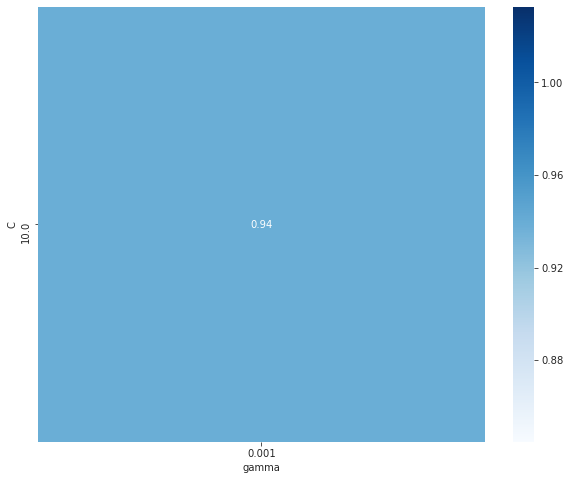

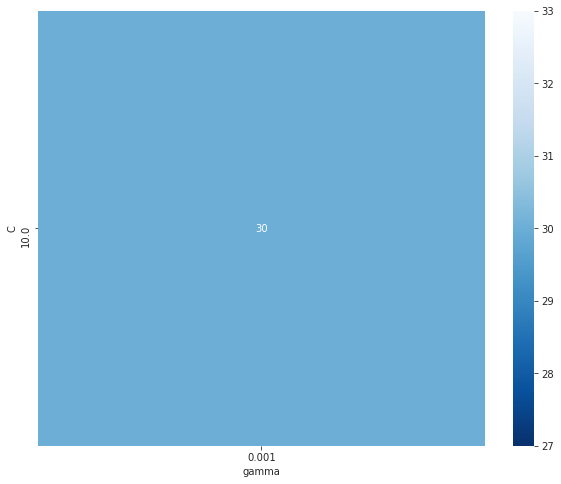

time: 284 ms


In [33]:
# Idea: Maybe make a utils folder, with a plotting module, evaluation module etc.. The below here should 
#       then be put in the plotting module. 
mean_test_scores = grid_trained.cv_results_['mean_test_score']
mean_fit_times = grid_trained.cv_results_['mean_fit_time']
param_columns = list(grid_trained.cv_results_['params'][0].keys())
result_columns = ['mean_fit_time', 'mean_test_score']
num_fits = len(grid_trained.cv_results_['params'])

df_cv_results = pd.DataFrame(0, index=range(num_fits), columns=param_columns+result_columns)
for i, param_set in enumerate(grid_trained.cv_results_['params']):
    for param, value in param_set.items():
        df_cv_results.loc[i, param] = value 
    df_cv_results.loc[i, 'mean_test_score'] = mean_test_scores[i]
    df_cv_results.loc[i, 'mean_fit_time'] = mean_fit_times[i]
    
df_heatmap_mean_score = df_cv_results.pivot(index='C', columns='gamma', values='mean_test_score')
plt.figure(figsize=(10,8))
ax = sns.heatmap(df_heatmap_mean_score, annot=True, cmap=plt.cm.Blues)

df_heatmap_fit_time = df_cv_results.pivot(index='C', columns='gamma', values='mean_fit_time')
plt.figure(figsize=(10,8))
ax = sns.heatmap(df_heatmap_fit_time.astype('int64'), annot=True, fmt='d', cmap=plt.cm.Blues_r)

In [16]:
try:
    from pycm import ConfusionMatrix
except:
    !pip install pycm
    from pycm import ConfusionMatrix

def numpy_confusion_matrix_to_pycm(confusion_matrix_numpy, labels=None):
    """Create a pycm confusion matrix from a NumPy confusion matrix
    Creates a confusion matrix object with the pycm library based on a confusion matrix as 2D NumPy array (such as
    the one generated by the sklearn confusion matrix function).
    See more about pycm confusion matrices at `pycm`_, and see more
    about sklearn confusion matrices at `sklearn confusion matrix`_.
    Args:
        confusion_matrix_numpy (np.array((num_classes, num_classes)) :
        labels (list) :
    Returns:
        confusion_matrix_pycm (pycm.ConfusionMatrix) :
    .. _`pycm`: https://github.com/sepandhaghighi/pycm
    .. _`sklearn confusion matrix`:
        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    """
    # Create empty dict to be used as input for pycm (see https://github.com/sepandhaghighi/pycm#direct-cm)
    confusion_matrix_dict = {}

    # Find number and classes and check labels
    num_classes = np.shape(confusion_matrix_numpy)[0]
    if not labels:  # If no labels are provided just use [0, 1, ..., num_classes]
        labels = range(num_classes)
    elif len(labels) != num_classes:
        raise AttributeError("Number of provided labels does not match number of classes.")

    # Fill the dict in the format required by pycm with values from the sklearn confusion matrix
    for row in range(num_classes):
        row_dict = {}
        for col in range(num_classes):
            row_dict[str(labels[col])] = int(confusion_matrix_numpy[row, col])
        confusion_matrix_dict[str(labels[row])] = row_dict

    # Instantiate the pycm confusion matrix from the dict
    confusion_matrix_pycm = ConfusionMatrix(matrix=confusion_matrix_dict)

    return confusion_matrix_pycm

time: 28.4 ms


In [27]:
pycm_confusion_matrix = numpy_confusion_matrix_to_pycm(cnf_matrix, labels=class_names)
print(pycm_confusion_matrix.ACC)

{'Forest': 0.9857142857142858, 'Maize': 0.9652631578947368, 'Permanent grass': 0.9061654135338346, 'Potato': 0.9768421052631578, 'Rapeseed': 0.9943609022556391, 'Spring barley': 0.9649624060150376, 'Spring oat': 0.9399248120300752, 'Spring wheat': 0.9722556390977444, 'Willow': 0.9874436090225563, 'Winter barley': 0.9869924812030075, 'Winter rye': 0.9788721804511278, 'Winter wheat': 0.9809022556390977}
time: 39.4 ms


In [31]:
pycm_confusion_matrix.stat()

Overall Statistics : 

95% CI                                                            (0.81332,0.82638)
ACC Macro                                                         0.96997
ARI                                                               0.69159
AUNP                                                              0.90055
AUNU                                                              0.863
Bennett S                                                         0.80347
CBA                                                               0.70724
CSI                                                               0.58506
Chi-Squared                                                       89608.54455
Chi-Squared DF                                                    121
Conditional Entropy                                               0.95203
Cramer V                                                          0.78262
Cross Entropy                                                     3.45148
F1 Macr